# Homogenization Model

## Example - Fe-Cr-Ni system

The homogenization model can simulate multiphase diffusion without having to resort to more complex methods such as phase field modeling. The model relies on the assumption that every volume element is in local equilibrium. Then fluxes are determined by the mobility and chemical potential gradient.

$$ J_k = -\Gamma_k^* \frac{\partial \mu_k^{eq}}{\partial z} $$

$$ \Gamma_k^\phi = M_k^\phi x_k^\phi $$

$$ \Gamma_k^* = f(\Gamma_k^\alpha, \Gamma_k^\beta, ...) $$

$\Gamma_k^*$ is an average mobility term that assumes certain geometry in the system. The following averaging functions are available in kawin:

1. Upper Wiener - assumes phases are continuous layers parallel to flux
2. Lower Wiener - assumes phases are continuous layers orthogonal to flux
3. Upper Hashin-Shtrikman - assumes a matrix of the phase with the fastest mobility with spheres of all other phases
4. Lower Hashin-Shtrikman - assumes a matrix of the phase with the slowest mobility with spheres of all other phases
5. Labyrinth - assumes phases as precipitates

Note that the Hashin-Shtrikman bounds are much narrower than the Wiener bounds.

The fluxes are calculated in a lattice fixed frame of reference. To convert to a volume fixed frame, the flux is then defined by:

$$ J_k^v = J_k - x_k \sum{J_j} $$

In this example a Fe-25.7Cr-6.5Ni / Fe-42.3Cr-27.6Ni diffusion couple will be simulated using the lower and upper Hashin-Shtrikman bounds. Both sides of the diffusion couple are $\alpha+\gamma$.

The first step is the load the thermodynamic database.

In [1]:
import matplotlib.pyplot as plt
from kawin.thermo import GeneralThermodynamics
from kawin.diffusion import HomogenizationModel
from kawin.solver import explicitEulerIterator

elements = ['FE', 'CR', 'NI']
phases = ['FCC_A1', 'BCC_A2']

therm = GeneralThermodynamics('FeCrNi.tdb', elements, phases)

In [2]:
from kawin.diffusion import HomogenizationParameters
from kawin.diffusion.mesh import Cartesian1D, ProfileBuilder, StepProfile1D

profile = ProfileBuilder()
profile.addBuildStep(StepProfile1D(0, [0.257, 0.065], [0.423, 0.276]), ['CR', 'NI'])
mesh = Cartesian1D(['CR', 'NI'], [-5e-4, 5e-4], 200)
mesh.setResponseProfile(profile)

temperature = 1100+273.15

mobLower = HomogenizationParameters(homogenizationFunction='hashin lower', eps=0.01)
mobUpper = HomogenizationParameters(homogenizationFunction='hashin upper', eps=0.01)

Defining the homogenization model is similar to defining the single phase diffusion model where the bounds of the domain, the number of volume elements, the defined elements and the defined phases are needed.

As with the single phase diffusion model, inputting the composition profile and parameters are also the same. The only difference is that two extra parameters will be defined for the homogenization model:

Smoothing factor ($\varepsilon$) - this factor allows for the composition to smooth out when the chemical potential gradient is zero but the composition gradient is non-zero (in n-phase regions where n is the number of components). This can be viewed as an ideal contribution where the composition smoothes out to maximize entropy. By default, it is set to 0.05, but here, we will set it to 0.01.

Mobility function - this defined which of the above mentioned mobility functions to use. We will start with the lower Hashin-Shtrikman bounds.

Solving the model is also similar to the single phase diffusion model.

In [3]:
ml = HomogenizationModel(mesh, elements, phases, 
                         thermodynamics=therm,
                         temperature=temperature,
                         homogenizationParameters=mobLower, record=False)
ml.solve(100*3600, iterator=explicitEulerIterator, verbose=True, vIt=500)

Iteration	Sim Time (h)	Run time (s)
0		0.0e+00		0.0
240		1.0e+02		30.4


The next model will be the exact same except the mobility function will be switched to the upper Hashin-Shtrikman bounds.

In [4]:
mu = HomogenizationModel(mesh, elements, phases,
                         thermodynamics=therm,
                         temperature=temperature,
                         homogenizationParameters=mobUpper, record=False)
mu.solve(100*3600, iterator=explicitEulerIterator, verbose=True, vIt=500)

Iteration	Sim Time (h)	Run time (s)
0		0.0e+00		0.0
500		1.4e+01		45.6
1000		2.9e+01		80.5
1500		4.3e+01		101.5
2000		5.8e+01		117.8
2500		7.3e+01		131.2
3000		8.7e+01		144.1
3439		1.0e+02		160.1


To compare the two mobility functions, the Cr composition, Ni composition and $\alpha$ phase fraction profile will be plotted. By default, the plotting functions will plot all components or phases; however, an individual component or phase can be defined to have it be the only thing that is plotted.

Here, we can see that the upper Hashin-Shtrikman bounds gives a smoother Cr and Ni profile. Additionally, the lower Hashin-Shtrikman bounds shows a pure $\gamma$ layer near the interface of around 4-6 $\mu m$.

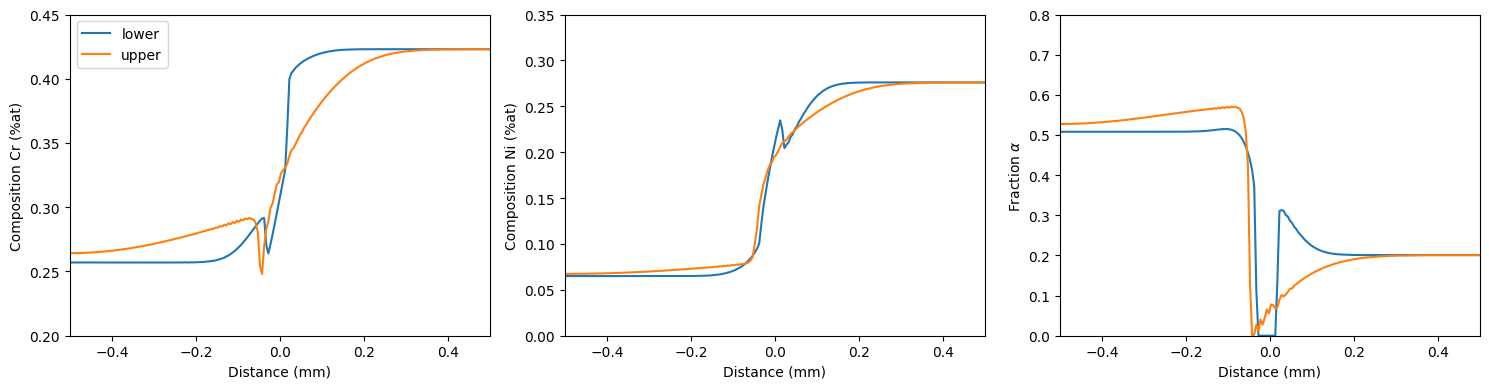

In [5]:
from kawin.diffusion.Plot import plot1D, plot1DPhases

fig, ax = plt.subplots(1,3, figsize=(15,4))

plot1D(ml, 'CR', zScale=1e-3, ax=ax[0], label='lower')
plot1D(mu, 'CR', zScale=1e-3, ax=ax[0], label='upper')
ax[0].set_xlabel('Distance (mm)')
ax[0].set_ylabel('Composition Cr (%at)')
ax[0].set_ylim([0.2, 0.45])
ax[0].legend()

plot1D(ml, 'NI', zScale=1e-3, ax=ax[1], label='lower')
plot1D(mu, 'NI', zScale=1e-3, ax=ax[1], label='upper')
ax[1].set_xlabel('Distance (mm)')
ax[1].set_ylabel('Composition Ni (%at)')
ax[1].set_ylim([0, 0.35])

plot1DPhases(ml, 'BCC_A2', zScale=1e-3, ax=ax[2], label='lower')
plot1DPhases(mu, 'BCC_A2', zScale=1e-3, ax=ax[2], label='upper')
ax[2].set_xlabel('Distance (mm)')
ax[2].set_ylabel(r'Fraction $\alpha$')
ax[2].set_ylim([0, 0.8])
plt.tight_layout()
plt.show()

We can plot the composition profile on a phase diagram to further show the diffusion path and compare both mobility functions. Using the triangular plotting feature in pycalphad, the Fe-Cr-Ni ternary phase diagram can be plotted and the diffusion paths of the two homogenization models can be superimposed on top.

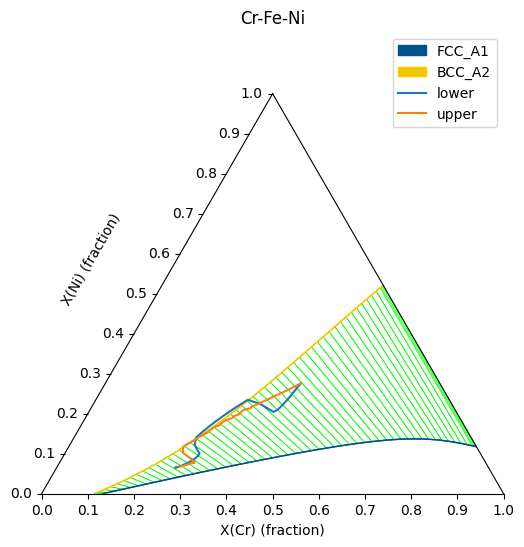

In [6]:
from pycalphad import ternplot, variables as v
from pycalphad.plot import triangular
from pycalphad.plot.utils import phase_legend

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='triangular')

conds = {v.T: 1100+273.15, v.P:101325, v.X('CR'): (0,1,0.015), v.X('NI'): (0,1,0.015)}
ternplot(therm.db, ['FE', 'CR', 'NI', 'VA'], phases, conds, x=v.X('CR'), y=v.X('NI'), ax = ax)

# Compositions will contain all elements (dependent, independent)
compl = ml.getCompositions()
ln1, = ax.plot(compl[:,1], compl[:,2], label='lower')

compu = mu.getCompositions()
ln2, = ax.plot(compu[:,1], compu[:,2], label='upper')

#The pycalphad ternplot function will automatically add a legend for the phases,
#but the legend has to be added again to add labels for the diffusion paths
handles, _ = phase_legend(phases)
ax.legend(handles = handles + [ln1, ln2])

plt.show()

### Periodic boundaries

Iteration	Sim Time (h)	Run time (s)
0		0.0e+00		0.0
240		1.0e+02		29.0


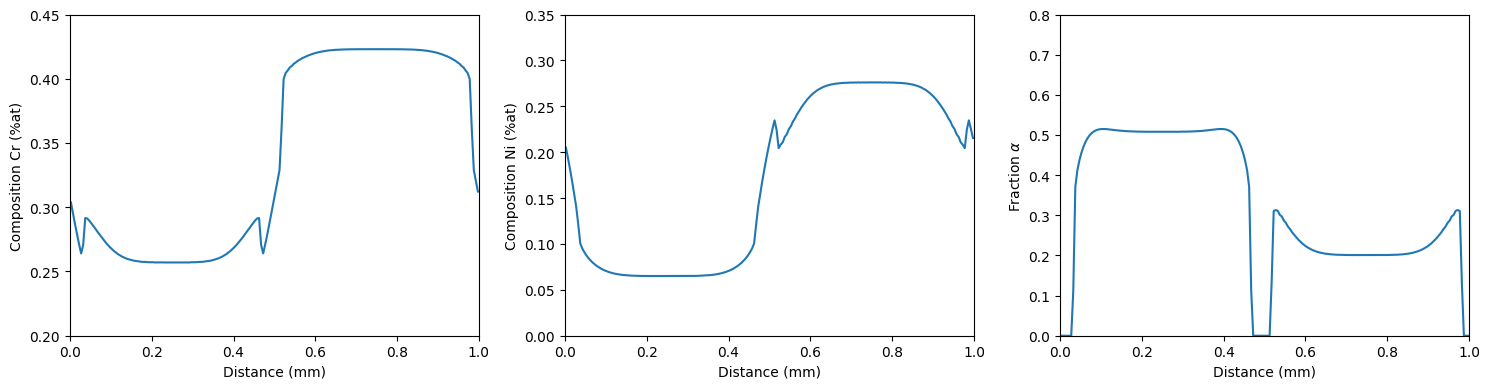

In [7]:
from kawin.diffusion.mesh import PeriodicBoundary1D

profile = ProfileBuilder()
profile.addBuildStep(StepProfile1D(0.5e-3, [0.257, 0.065], [0.423, 0.276]), ['CR', 'NI'])

mesh = Cartesian1D(['CR', 'NI'], [0, 1e-3], 200)
mesh.setResponseProfile(profile, boundaryConditions=PeriodicBoundary1D())

m = HomogenizationModel(mesh, elements, phases, 
                        thermodynamics=therm, temperature=temperature,
                        homogenizationParameters=mobLower, record=False)
m.solve(100*3600, iterator=explicitEulerIterator, verbose=True, vIt=500)

fig, ax = plt.subplots(1,3, figsize=(15,4))

plot1D(m, 'CR', zScale=1e-3, ax=ax[0])
ax[0].set_xlabel('Distance (mm)')
ax[0].set_ylabel('Composition Cr (%at)')
ax[0].set_ylim([0.2, 0.45])

plot1D(m, 'NI', zScale=1e-3, ax=ax[1])
ax[1].set_xlabel('Distance (mm)')
ax[1].set_ylabel('Composition Ni (%at)')
ax[1].set_ylim([0, 0.35])

plot1DPhases(m, 'BCC_A2', zScale=1e-3, ax=ax[2])
ax[2].set_xlabel('Distance (mm)')
ax[2].set_ylabel(r'Fraction $\alpha$')
ax[2].set_ylim([0, 0.8])
plt.tight_layout()
plt.show()

## References

1. H. Larsson and L. Hoglund, "Multiphase diffusion simulations in 1D using the DICTRA homogenization model" *Calphad* 33 (2009) p. 495
2. H. Larsson and A. Engstrom, "A homogenization approach to diffusion simulations applied to $\alpha+\gamma$ Fe-Cr-Ni diffusion couples" *Acta Materialia* 54 (2006) p. 2431